# Transfer Learning

The use of convolutions to extract features can
be a powerful tool for identifying the contents of an image. The resulting feature maps can then be fed into the dense layers of a neural network to match them to the labels and give us a more accurate way of determining the contents of an image. Using this approach, with a simple, fast-to-train neural network and some image augmentation techniques, we built a model that was 80–90% accurate at distinguishing between a horse and a human when trained on a very small dataset.

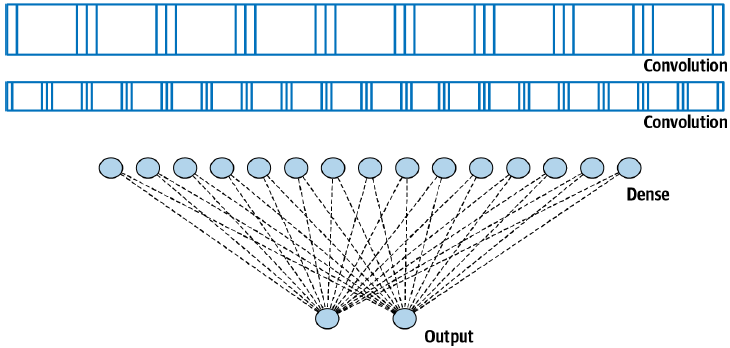

But we can improve our model even further using a method called transfer learning. The idea behind transfer learning is simple: instead of learning a set of filters from scratch for our dataset, why not use a set of filters that were learned on a much larger dataset, with many more features than we can ***“afford”*** to build from scratch? We can place these in our network and then train a model with our data using the prelearned filters.

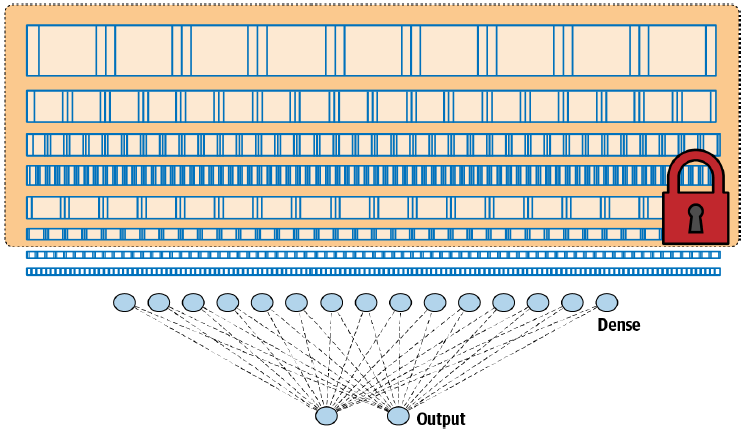

# Import Libraries

In [ ]:
import tensorflow as tf
import pathlib
import urllib.request
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers.legacy import RMSprop
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import urllib.request
import zipfile
from google.colab import files


# print tensorflow version
print(tf.__version__)

2.13.0


# Custom Keras Callback

In [ ]:
class KerasCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

# Download and Preprocess Dataset

In [ ]:
dataset_dir = 'datasets/PetImages'

# download the dataset
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
data_dir = tf.keras.utils.get_file('kagglecatsanddogs_5340.zip', origin=dataset_url, extract=True, cache_dir='./')
data_dir = pathlib.Path(dataset_dir).with_suffix('')

# total images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

824887076/824887076 [==============================] - 9s 0us/step
25000


# Filter-out Corrupt Images

In [ ]:
num_skipped = 0
should_rewrite_image = True
for data_dir in ('Cat', 'Dog'):
    folder_path = os.path.join(dataset_dir, data_dir)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        is_jfif = True
        should_remove = False

        with open(fpath, "rb") as fobj:
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)

        try:
            img = tf.io.read_file(fpath)
            if not tf.io.is_jpeg(img):
                should_remove = True

            img = tf.image.decode_image(img)

            if img.ndim != 3:
                should_remove = True
        except:
            should_remove = True

        if (not is_jfif) or should_remove:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        elif should_rewrite_image:
            tmp = tf.io.encode_jpeg(img)
            tf.io.write_file(fpath, tmp)

print('Deleted %d images' % num_skipped)

Deleted 1592 images


# Generate Training and Validation Dataset

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
['Cat', 'Dog']


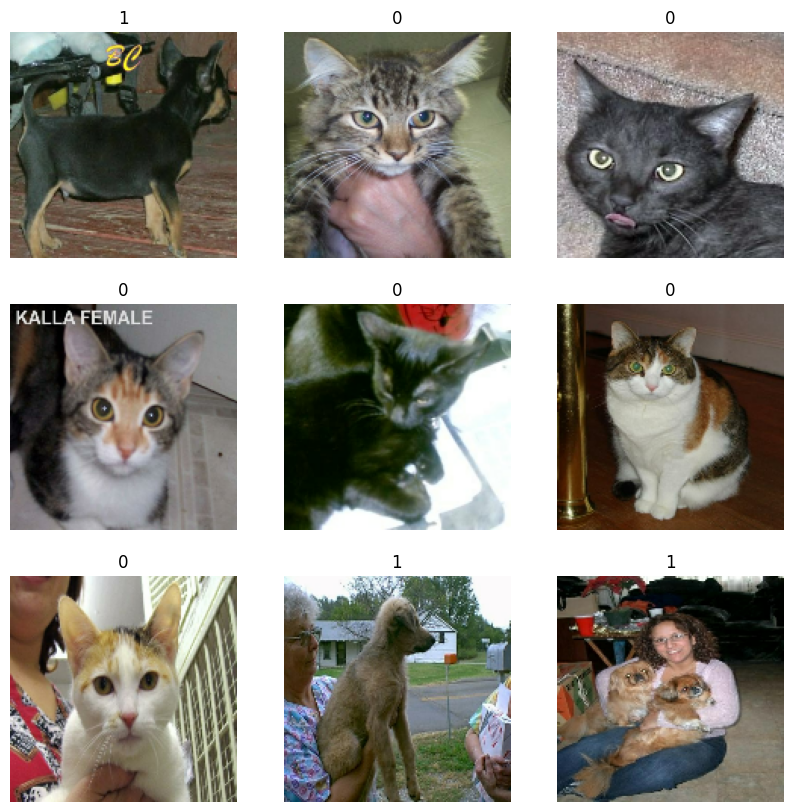

In [ ]:
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 200

# training split
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# validation split
validation_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# print the labels / class names
class_names = train_ds.class_names
print(class_names)

# show few images from training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Create Test Dataset

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 20
Number of test batches: 4


# Configure the Dataset for Performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [ ]:
# normalization
normalization = tf.keras.layers.Rescaling(1./255)

# augmentaion
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    normalization,
])

# apply augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_ds = validation_ds.map(lambda x, y: (normalization(x, training=True), y))
test_ds = test_ds.map(lambda x, y: (normalization(x), y))

# Create the Base Model

In [ ]:
# create base model
base_model = InceptionV3(
    weights='imagenet',
    include_top=False
)

# layers must not be trainable
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


# Compile the Model

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# add a final sigmoid layer for classification
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Retrain the Model

In [ ]:
initial_epochs = 50

# create the callback
callback = KerasCallback()

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=initial_epochs,
    callbacks=[callback]
)

Epoch 1/50
94/94 [==============================] - 101s 894ms/step - loss: 0.5022 - accuracy: 0.8772 - val_loss: 0.0955 - val_accuracy: 0.9624
Epoch 2/50
94/94 [==============================] - 81s 841ms/step - loss: 0.1740 - accuracy: 0.9252 - val_loss: 0.0823 - val_accuracy: 0.9688
Epoch 3/50
94/94 [==============================] - 83s 860ms/step - loss: 0.1601 - accuracy: 0.9332 - val_loss: 0.0854 - val_accuracy: 0.9683
Epoch 4/50
94/94 [==============================] - 77s 802ms/step - loss: 0.1569 - accuracy: 0.9334 - val_loss: 0.1003 - val_accuracy: 0.9603
Epoch 5/50
94/94 [==============================] - 78s 817ms/step - loss: 0.1543 - accuracy: 0.9353 - val_loss: 0.0899 - val_accuracy: 0.9652
Epoch 6/50
94/94 [==============================] - 81s 842ms/step - loss: 0.1526 - accuracy: 0.9356 - val_loss: 0.0835 - val_accuracy: 0.9683
Epoch 7/50
94/94 [==============================] - 82s 851ms/step - loss: 0.1422 - accuracy: 0.9392 - val_loss: 0.0787 - val_accuracy: 0.969

# Plot the Learning Curve

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


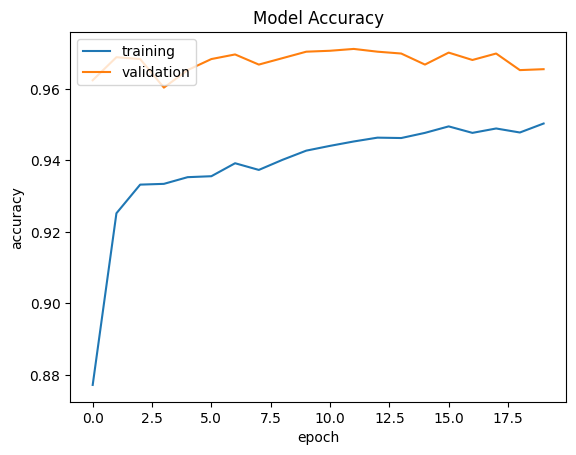

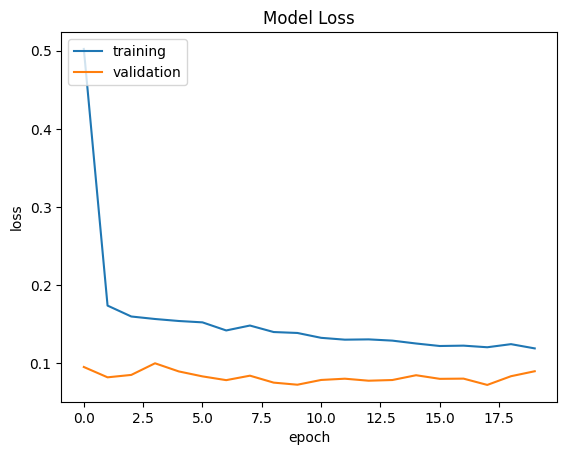

In [ ]:
print(history.history.keys())

training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
vavlidation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# plot accuracy training vs. validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# plot loss training vs. validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Save the Model

In [ ]:
model.save('cats_or_dogs.keras')
files.download('cats_or_dogs.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate Model

In [ ]:
model.evaluate(test_ds)

4/4 [==============================] - 3s 218ms/step - loss: 0.1011 - accuracy: 0.9563


[0.10114942491054535, 0.956250011920929]

# Test with Images

In [ ]:
# function for prediction / inference
def predict_cat_or_dog(image_name, img_array):
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  classes = model.predict(img_array)
  result = classes[0]

  if result > 0.5:
    print(f'{result} | {image_name} is a dog!')
  else:
    print(f'{result} | {image_name} is a cat!')

# download images
actual_images_dl = 'https://drive.google.com/uc?export=download&id=1uTks_8b50_R4XAvOsCa7thWx4F35oI-L'
filename = "cad_actual_samples.zip"
dir = 'cad_actual_samples'

urllib.request.urlretrieve(actual_images_dl, filename)

# extract to directory
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(dir)
zip_ref.close()

1/1 [==============================] - 0s 25ms/step
[0.9999994] | dog1.jpg is a dog!


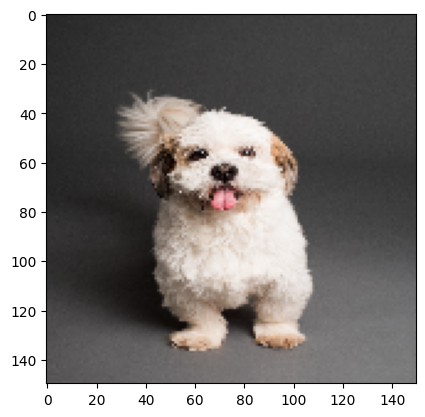

In [ ]:
# load the image to test
image_name = 'dog1.jpg'
img_array = tf.keras.utils.load_img(f'{dir}/{image_name}',target_size=IMAGE_SIZE)
plt.imshow(img_array)
img_array = normalization(img_array)
predict_cat_or_dog(image_name, img_array)

1/1 [==============================] - 0s 26ms/step
[0.00328392] | cat1.jpg is a cat!


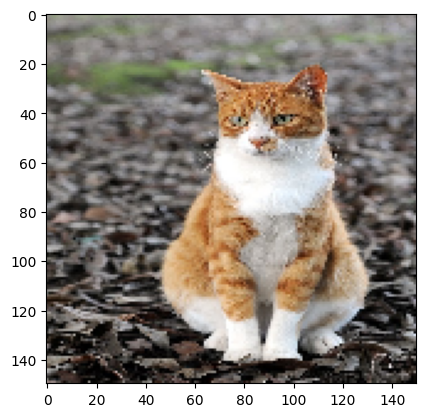

In [ ]:
# load the image to test
image_name = 'cat1.jpg'
img_array = tf.keras.utils.load_img(f'{dir}/{image_name}',target_size=IMAGE_SIZE)
plt.imshow(img_array)
img_array = normalization(img_array)
predict_cat_or_dog(image_name, img_array)

1/1 [==============================] - 0s 28ms/step
[0.99947065] | dog2.jpg is a dog!


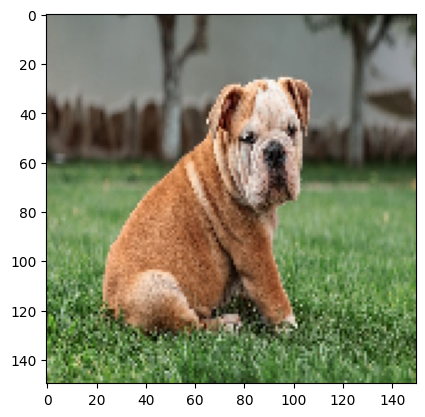

In [ ]:
# load the image to test
image_name = 'dog2.jpg'
img_array = tf.keras.utils.load_img(f'{dir}/{image_name}',target_size=IMAGE_SIZE)
plt.imshow(img_array)
img_array = normalization(img_array)
predict_cat_or_dog(image_name, img_array)

1/1 [==============================] - 0s 25ms/step
[0.00016168] | cat2.jpg is a cat!


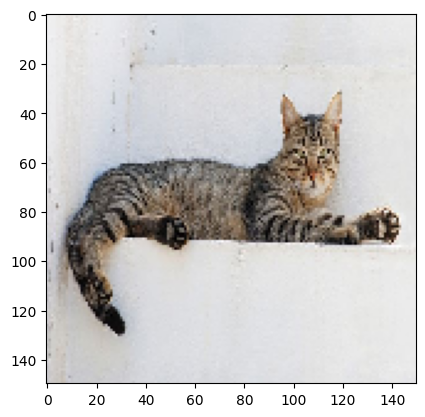

In [ ]:
# load the image to test
image_name = 'cat2.jpg'
img_array = tf.keras.utils.load_img(f'{dir}/{image_name}',target_size=IMAGE_SIZE)
plt.imshow(img_array)
img_array = normalization(img_array)
predict_cat_or_dog(image_name, img_array)

1/1 [==============================] - 0s 26ms/step
[0.99937516] | dog3.jpg is a dog!


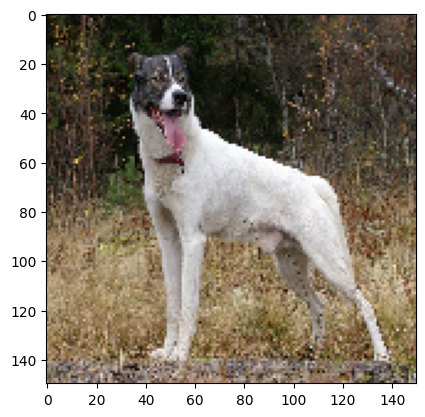

In [ ]:
# load the image to test
image_name = 'dog3.jpg'
img_array = tf.keras.utils.load_img(f'{dir}/{image_name}',target_size=IMAGE_SIZE)
plt.imshow(img_array)
img_array = normalization(img_array)
predict_cat_or_dog(image_name, img_array)

1/1 [==============================] - 0s 29ms/step
[0.00828881] | puss.webp is a cat!


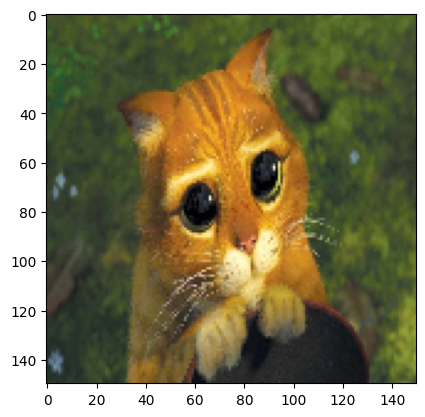

In [ ]:
# load the image to test
image_name = 'puss.webp'
img_array = tf.keras.utils.load_img(f'{dir}/{image_name}',target_size=IMAGE_SIZE)
plt.imshow(img_array)
img_array = normalization(img_array)
predict_cat_or_dog(image_name, img_array)

In [ ]:
# upload your own image to test
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  result = classes[0]
  predict_cat_or_dog(path, result)